11376681
一共有 9 个pkl文件
一共有 2 个csv文件


9840631756268536    0.983278
9841653409665807    0.983697
9868913650512696    0.992047
9870823860168457    0.992710
9868765592575074    0.992918
9870319247245787    0.993101
9870270013809204    0.993222
9870001316070557    0.993508
9869                0.993608
9868                0.994672
dtype: float64

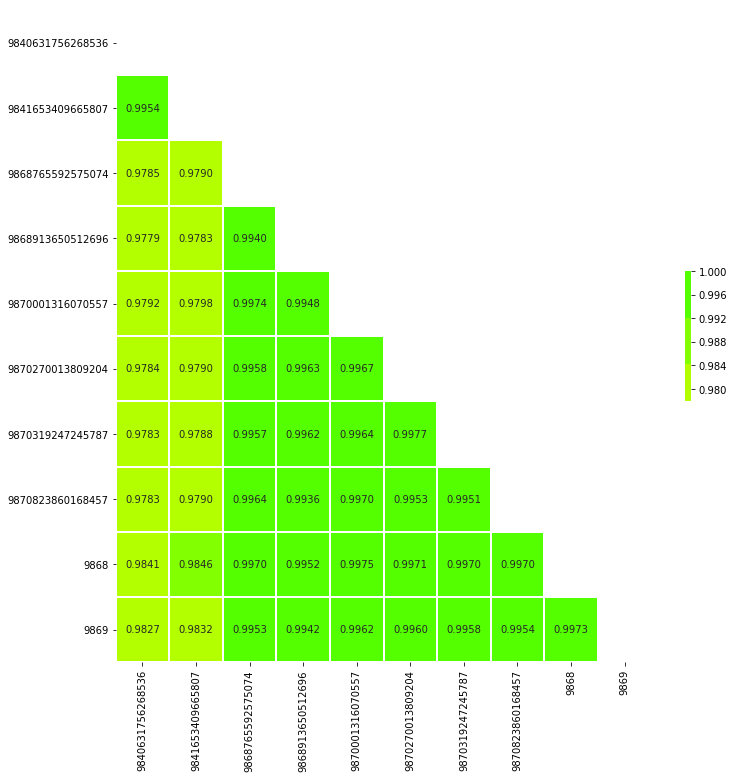

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score
from scipy.stats import entropy, kurtosis
from gensim.models import Word2Vec
import time
import gc
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
pd.set_option('display.max_columns', None)
oof = {}
pred = {}
oof_nameList = []
labels = joblib.load("labels.pkl")
sub = pd.read_csv('dataset/sample.csv')
print(len(labels))
for i in os.listdir(r"stacking/stacking/"):
    if i.split('.')[-1]!="pkl":
        continue
    tar1 = pd.read_pickle("stacking/stacking/"+i)
    oof_name = i.split('.')[0].split('_')[-1]
    pred[oof_name] = tar1['pred']

print("一共有",len(os.listdir("stacking/stacking/")),"个pkl文件")
for i in os.listdir(r"stacking/stacking/csv/"):
    tar1 = pd.read_csv("stacking/stacking/csv/"+i)
    oof_name = i.split('.')[0].split('_')[-1]
    pred[oof_name] = tar1['target']
    
print("一共有",len(os.listdir("stacking/stacking/csv/")),"个csv文件")
oof["labels"] = labels
oof = pd.DataFrame(oof)
pred = pd.DataFrame(pred)
# check correlation
corr = pred.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cols = pred.columns
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:]
mean_corr

In [26]:

m_gmean1 = 0
for n in mean_corr.index:
    m_gmean1 += np.log(pred[n])
m_gmean1 = np.exp(m_gmean1/len(mean_corr))
rank = np.tril(corr.values,-1)
rank[rank<0.92] = 1
m = (rank>0).sum() - (rank>0.98).sum()
m_gmean2, s = 0, 0
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/m
    m_gmean2 += w*(np.log(pred.iloc[:,mx[0]])+np.log(pred.iloc[:,mx[1]]))/2
    s += w
    rank[mx] = 1
m_gmean2 = np.exp(m_gmean2/s)
# select Top N score to blending...
top_mean = 0
topN = 7 
s = 0
sortedColumns = sorted(pred.columns)[::-1]
print(sortedColumns)


for n in sortedColumns[:topN]:
    top_mean += pred[n]*float(n)
    s += float(n)
top_mean /= s
m_gmean = np.exp(0.1*np.log(m_gmean1) + 0.8*np.log(m_gmean2) + 0.1*np.log(top_mean))
describe(m_gmean)



threshold = 0.374
sub.target = (m_gmean > threshold).astype(np.int8)
sub.head()
sub.to_csv('{}_top_{}_m_gmean_targetmean_{}_all_2.csv'.format(threshold,topN,sub["target"].mean()), index=False)

print('{}_top_{}_m_gmean_targetmean_{}.csv'.format(threshold,topN,sub["target"].mean()))

['9870823860168457', '9870319247245787', '9870270013809204', '9870001316070557', '9869', '9868913650512696', '9868765592575074', '9868', '9841653409665807', '9840631756268536']
0.374_top_7_m_gmean_targetmean_0.10794992982248702.csv


9840631756268536    0.983281
9841653409665807    0.983685
9887829184532165    0.991913
9870823860168457    0.991963
9868765592575074    0.992234
9870319247245787    0.992324
dtype: float64

['9887829184532165', '9870823860168457', '9870319247245787', '9870270013809204', '9870001316070557', '9868765592575074', '9841653409665807', '9840631756268536']


DescribeResult(nobs=3653592, minmax=(0.0, 0.9999176186392978), mean=0.09955697555401528, variance=0.06264413100479366, skewness=2.624252066290245, kurtosis=5.459983283353054)